In [1]:
from collections import defaultdict
import os, urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn, sklearn.model_selection, sklearn.linear_model

from projection_simplex_vectorized import projection_simplex
import postprocess

split_ratio_for_postprocessing = 0.5

seed = 33
rng = np.random.default_rng(seed)
noise_fn = lambda shape: rng.laplace(loc=0.0, scale=0.2 / 2, size=shape)
n_perturbations = 60

## Download and pre-process UCI Adult dataset

In [2]:
features = [
    "Age", "Workclass", "fnlwgt", "Education", "Education-Num",
    "Martial Status", "Occupation", "Relationship", "Race", "Sex",
    "Capital Gain", "Capital Loss", "Hours per week", "Country", "Target"
]

train_path = "data/adult/adult.data"
test_path = "data/adult/adult.test"
if any([not os.path.exists(p) for p in [train_path, test_path]]):
  os.makedirs("data/adult", exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
      train_path)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
      test_path)

original_train = pd.read_csv(train_path,
                             names=features,
                             sep=r"\s*,\s*",
                             engine="python",
                             na_values="?")
original_test = pd.read_csv(test_path,
                            names=features,
                            sep=r"\s*,\s*",
                            engine="python",
                            na_values="?",
                            skiprows=1)

original_train["Age-Binned"] = np.where(original_train["Age"] <= 50, "<=50",
                                        ">50")
original_test["Age-Binned"] = np.where(original_test["Age"] <= 50, "<=50",
                                       ">50")

In [3]:
def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


original = pd.concat([original_train, original_test])
labels_original = original[["Target"
                           ]].replace("<=50K.",
                                      "<=50K").replace(">50K.", ">50K")
del original["Target"]
n_train = len(original_train)

label_names, labels = np.unique(labels_original, return_inverse=True)
n_labels = len(label_names)

data = data_transform(original)
train_data = data[:n_train]
train_labels = labels[:n_train]
test_data = data[n_train:]
test_labels = labels[n_train:]

In [4]:
def get_group_labels_and_print_statistics(sensitive_attributes):

  group_names, groups = np.unique(
      original[sensitive_attributes].to_numpy().astype(str),
      return_inverse=True,
      axis=0)
  n_groups = len(group_names)
  print("Demographic groups:",
        ', '.join(["'" + ', '.join(n) + "'" for n in group_names]))
  train_groups = groups[:n_train]
  test_groups = groups[n_train:]

  # Compute dataset statistics
  df = original.copy()
  df["Target"] = labels_original
  group_column = original[sensitive_attributes[0]]
  for attribute in sensitive_attributes[1:]:
    group_column = np.add(np.add(group_column, ", "), original[attribute])
  df["Group"] = group_column
  grouped = df.groupby(["Target", "Group"]).size().unstack()
  n_labels = len(grouped.index)
  n_groups = len(grouped.columns)
  counts = grouped.sum(axis=0)
  normalized = np.nan_to_num((grouped.to_numpy() / counts.to_numpy())).T
  diff = np.abs(normalized[:, None, :] - normalized[None, :, :])
  postprocessor = postprocess.PostProcessorDP()
  postprocessor.fit(np.concatenate([np.eye(n_labels) for _ in range(n_groups)],
                                   axis=0),
                    np.repeat(np.arange(n_groups), n_labels),
                    p=normalized.flatten())
  res = {
      "balanced_accuracy": {
          "perfect_postprocessed": (n_groups - postprocessor.score_) / n_groups
      },
      "dp_gap_linf_max": {
          "perfect_predictor": np.max(diff)
      },
      "dp_gap_l1_max": {
          "perfect_predictor": np.max(1 / 2 * np.sum(diff, axis=2))
      },
      "dp_gap_l1_avg": {
          "perfect_predictor":
              np.mean(1 / 2 * np.sum(diff, axis=2)[np.triu_indices(n_groups, 1)]
                     )
      },
  }

  display(pd.DataFrame(res))
  display(grouped / counts)
  display(pd.DataFrame(counts, columns=["Count"]).T)

  return train_groups, test_groups, n_groups

## Sensitive attribute "Sex"

In [5]:
sensitive_attributes = ["Sex"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Demographic groups: 'Female', 'Male'


,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
perfect_postprocessed,0.902742,NaN,NaN,NaN
perfect_predictor,NaN,0.194516,0.194516,0.194516


Group,Female,Male
Target,,
<=50K,0.890749,0.696233
>50K,0.109251,0.303767


Group,Female,Male
Count,16192,32650


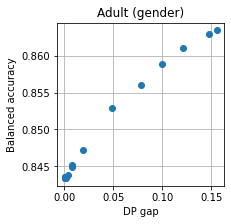

,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.843929,0.863517,0.155611,0.155611,0.155611
0.15,0.843560,0.863056,0.147504,0.147504,0.147504
0.12,0.841103,0.861076,0.120880,0.120880,0.120880
0.1,0.838093,0.858866,0.099506,0.099506,0.099506
0.08,0.834347,0.856012,0.078132,0.078132,0.078132
0.05,0.830600,0.852972,0.049018,0.049018,0.049018
0.02,0.824397,0.847167,0.018797,0.018797,0.018797
0.01,0.822615,0.845232,0.007923,0.007923,0.007923
0.008,0.822308,0.844909,0.007278,0.007278,0.007278
0.005,0.821203,0.843803,0.003961,0.003961,0.003961


In [6]:
eps = [
    0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001, 0.0008,
    0.0005, 0.0002, 0.0001, 0.0
]
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
res = defaultdict(dict)
for e in eps:
  postprocessor = postprocess.postprocess(predict_fn,
                                          train_data_post,
                                          train_groups_post,
                                          eps=e)
  r = postprocess.evaluate(predict_fn, postprocessor, test_data, test_labels,
                           test_groups, n_labels, n_groups)
  for k, v in r.items():
    res[k]["inf"] = v["predictor"]
    res[k][e] = v["postprocessor"]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(res["dp_gap_l1_max"].values(),
           res["balanced_accuracy"].values(),
           zorder=2)
ax.set_xlabel("DP gap")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Adult (gender)")
ax.grid(True, which="both", zorder=0)
plt.show()
display(pd.DataFrame(res))

In [7]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
postprocessor = postprocess.postprocess(predict_fn,
                                        train_data_post,
                                        train_groups_post,
                                        noise_fn=noise_fn,
                                        n_perturbations=n_perturbations)
r = postprocess.evaluate(predict_fn,
                         postprocessor,
                         test_data,
                         test_labels,
                         test_groups,
                         n_labels,
                         n_groups,
                         noise_fn=noise_fn,
                         n_perturbations=1000)
res = {
    k: {
        "inf": v["predictor"],
        0.0: v["postprocessor"]
    } for k, v in r.items()
}
print("With Laplace smoothing:")
display(pd.DataFrame(res))

With Laplace smoothing:


,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.829998,0.851108,0.162740,0.162740,0.162740
0.0,0.813439,0.834265,0.000046,0.000046,0.000046


## Sensitive attribute "Race"

In [8]:
sensitive_attributes = ["Race"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Demographic groups: 'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White'


,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
perfect_postprocessed,0.942918,NaN,NaN,NaN
perfect_predictor,NaN,0.152235,0.152235,0.087529


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Target,,,,,
<=50K,0.882979,0.730744,0.879189,0.876847,0.746013
>50K,0.117021,0.269256,0.120811,0.123153,0.253987


Group,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
Count,470,1519,4685,406,41762


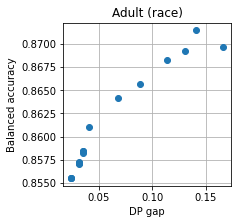

,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.843929,0.869696,0.166392,0.166392,0.088722
0.15,0.843990,0.871470,0.141274,0.141274,0.078575
0.12,0.843314,0.869195,0.130857,0.130857,0.072871
0.1,0.843314,0.868276,0.114190,0.114190,0.065624
0.08,0.841594,0.865696,0.088625,0.088625,0.051606
0.05,0.836005,0.864111,0.067593,0.067593,0.040238
0.02,0.830477,0.861004,0.040776,0.040776,0.020351
0.01,0.828143,0.858411,0.035185,0.035185,0.015693
0.008,0.828143,0.858411,0.035185,0.035185,0.015636
0.005,0.827406,0.858239,0.035185,0.035185,0.015091


In [9]:
eps = [
    0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001, 0.0008,
    0.0005, 0.0002, 0.0001, 0.0
]
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
res = defaultdict(dict)
for e in eps:
  postprocessor = postprocess.postprocess(predict_fn,
                                          train_data_post,
                                          train_groups_post,
                                          eps=e)
  r = postprocess.evaluate(predict_fn, postprocessor, test_data, test_labels,
                           test_groups, n_labels, n_groups)
  for k, v in r.items():
    res[k]["inf"] = v["predictor"]
    res[k][e] = v["postprocessor"]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(res["dp_gap_l1_max"].values(),
           res["balanced_accuracy"].values(),
           zorder=2)
ax.set_xlabel("DP gap")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Adult (race)")
ax.grid(True, which="both", zorder=0)
plt.show()
display(pd.DataFrame(res))

In [10]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
postprocessor = postprocess.postprocess(predict_fn,
                                        train_data_post,
                                        train_groups_post,
                                        noise_fn=noise_fn,
                                        n_perturbations=n_perturbations)
r = postprocess.evaluate(predict_fn,
                         postprocessor,
                         test_data,
                         test_labels,
                         test_groups,
                         n_labels,
                         n_groups,
                         noise_fn=noise_fn,
                         n_perturbations=1000)
res = {
    k: {
        "inf": v["predictor"],
        0.0: v["postprocessor"]
    } for k, v in r.items()
}
print("With Laplace smoothing:")
display(pd.DataFrame(res))

With Laplace smoothing:


,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.829985,0.859041,0.147615,0.147615,0.081136
0.0,0.821585,0.850282,0.027759,0.027759,0.013688


## Sensitive attribute "Sex" + "Race"

In [11]:
sensitive_attributes = ["Sex", "Race"]
train_groups, test_groups, n_groups = get_group_labels_and_print_statistics(sensitive_attributes)
train_data_pre, train_data_post, train_labels_pre, train_labels_post, train_groups_pre, train_groups_post = sklearn.model_selection.train_test_split(
    train_data,
    train_labels,
    train_groups,
    test_size=split_ratio_for_postprocessing,
    random_state=seed)
train_labels_pre_one_hot = pd.get_dummies(train_labels_pre)

Demographic groups: 'Female, Amer-Indian-Eskimo', 'Female, Asian-Pac-Islander', 'Female, Black', 'Female, Other', 'Female, White', 'Male, Amer-Indian-Eskimo', 'Male, Asian-Pac-Islander', 'Male, Black', 'Male, Other', 'Male, White'


,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
perfect_postprocessed,0.932797,NaN,NaN,NaN
perfect_predictor,NaN,0.282129,0.282129,0.108358


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Target,,,,,,,,,,
<=50K,0.918919,0.866538,0.942808,0.929032,0.88163,0.859649,0.660679,0.817417,0.844622,0.684531
>50K,0.081081,0.133462,0.057192,0.070968,0.11837,0.140351,0.339321,0.182583,0.155378,0.315469


Group,"Female, Amer-Indian-Eskimo","Female, Asian-Pac-Islander","Female, Black","Female, Other","Female, White","Male, Amer-Indian-Eskimo","Male, Asian-Pac-Islander","Male, Black","Male, Other","Male, White"
Count,185,517,2308,155,13027,285,1002,2377,251,28735


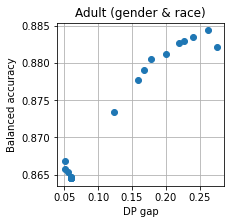

,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.843929,0.882178,0.275081,0.275081,0.090627
0.25,0.843929,0.884409,0.262136,0.262136,0.088350
0.22,0.843621,0.883554,0.239482,0.239482,0.082993
0.2,0.843499,0.882907,0.226232,0.226232,0.076956
0.18,0.843499,0.882662,0.219329,0.219329,0.073743
0.15,0.840857,0.881165,0.199665,0.199665,0.065640
0.12,0.836374,0.880470,0.177492,0.177492,0.058275
0.1,0.833917,0.878992,0.168288,0.168288,0.054486
0.08,0.831276,0.877769,0.158576,0.158576,0.049686
0.05,0.824581,0.873420,0.123941,0.123941,0.038002


In [12]:
eps = [
    0.25, 0.22, 0.2, 0.18, 0.15, 0.12, 0.1, 0.08, 0.05, 0.02, 0.01, 0.008,
    0.005, 0.002, 0.001, 0.0008, 0.0005, 0.0002, 0.0001, 0.0
]
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
res = defaultdict(dict)
for e in eps:
  postprocessor = postprocess.postprocess(predict_fn,
                                          train_data_post,
                                          train_groups_post,
                                          eps=e)
  r = postprocess.evaluate(predict_fn, postprocessor, test_data, test_labels,
                           test_groups, n_labels, n_groups)
  for k, v in r.items():
    res[k]["inf"] = v["predictor"]
    res[k][e] = v["postprocessor"]

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(res["dp_gap_l1_max"].values(),
           res["balanced_accuracy"].values(),
           zorder=2)
ax.set_xlabel("DP gap")
ax.set_ylabel("Balanced accuracy")
ax.set_title("Adult (gender & race)")
ax.grid(True, which="both", zorder=0)
plt.show()
display(pd.DataFrame(res))

In [13]:
predictor = sklearn.linear_model.LinearRegression()
predictor.fit(train_data_pre, train_labels_pre_one_hot)
predict_fn = lambda X: projection_simplex(predictor.predict(X), axis=1)
postprocessor = postprocess.postprocess(predict_fn,
                                        train_data_post,
                                        train_groups_post,
                                        noise_fn=noise_fn,
                                        n_perturbations=n_perturbations)
r = postprocess.evaluate(predict_fn,
                         postprocessor,
                         test_data,
                         test_labels,
                         test_groups,
                         n_labels,
                         n_groups,
                         noise_fn=noise_fn,
                         n_perturbations=1000)
res = {
    k: {
        "inf": v["predictor"],
        0.0: v["postprocessor"]
    } for k, v in r.items()
}
print("With Laplace smoothing:")
display(pd.DataFrame(res))

With Laplace smoothing:


,accuracy,balanced_accuracy,dp_gap_linf_max,dp_gap_l1_max,dp_gap_l1_avg
inf,0.830010,0.872342,0.258046,0.258046,0.090094
0.0,0.807328,0.854477,0.065245,0.065245,0.022584
